<a href="https://colab.research.google.com/github/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data/blob/main/ConvAI_using_LLMs_on_E_commerce_Data_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow==2.8.1
!pip install --upgrade tensorflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [2]:
!pip install kaggle
!pip install xlsxwriter

!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece] datasets
!pip install sentencepiece
!pip install openai cohere tiktoken rouge nltk rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 6.8 MB/s eta 0:00

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [3]:
import tensorflow as tf

# Print the TensorFlow version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [4]:
import openai as OpenAI

# Print the TensorFlow version
print("OpenAI version:", OpenAI.__version__)


OpenAI version: 1.12.0


In [5]:
#Basic Libraries
import os
import numpy as np
import pandas as pd
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Text Handling Libraries
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import xlsxwriter
import scipy.spatial
import datetime

from datasets import load_dataset
from transformers import pipeline



In [6]:
import yaml
import json

from google.colab import drive

# Mount Google Drive with force remount
drive.mount('/content/drive', force_remount=True)


# Load relevant API Keys
file_path = '/content/drive/MyDrive/.API_KEYS/API_KEYS.yml'

with open(file_path, 'r') as file:
    api_keys = yaml.safe_load(file)


# Extract Kaggle username and key
HF_READ_API_KEY = api_keys['HUGGINGFACE']['HF_READ_API_KEY']
HF_WRITE_API_KEY = api_keys['HUGGINGFACE']['HF_WRITE_API_KEY']



Mounted at /content/drive


In [7]:
%pwd

'/content'

In [8]:
!git clone https://github.com/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data.git

Cloning into 'Conversation-AI-System-using-LLMs-on-E-commerce-Data'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 77 (delta 42), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (77/77), 11.21 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [9]:
%cd Conversation-AI-System-using-LLMs-on-E-commerce-Data

/content/Conversation-AI-System-using-LLMs-on-E-commerce-Data


In [10]:
# Load Data
df = pd.read_csv("./OSS_LLMs_Data.csv")

In [11]:
############################################## Sentiment Analysis #########################33
# Sentiment Analysis with BERT
sentiment_classifier = pipeline(
    task="text-classification",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

# Example usage
result = sentiment_classifier("I love using this model!")
print("result :",result)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

result : [{'label': '5 stars', 'score': 0.8710660338401794}]


In [13]:

from tqdm import tqdm  # Import tqdm for the progress bar


df['BERT_label'], df['BERT_score'] = 0, 0

max_seq_length = 512  # Set your desired maximum sequence length

# Use tqdm to create a progress bar
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    try:
        # Truncate or split the text to fit within the model's maximum sequence length
        review_content = row['review_content'][:max_seq_length]

        results = sentiment_classifier(review_content)[0]
        df.at[index, 'label'], df.at[index, 'score'] = results['label'], round(results['score']*100, 2)

    except Exception as e:
        # Handle exceptions, e.g., if the text is too short
        print(f"Error processing index {index}: {e}")




Processing: 100%|██████████| 734/734 [00:39<00:00, 18.67it/s]


In [14]:
df.shape

(734, 28)

In [15]:
df.label.value_counts()

5 stars    579
1 star     155
Name: label, dtype: int64

In [16]:
# Define the mapping dictionary
star_rating_mapping = {
    '5 stars': 'Very Positive',
    '4 stars': 'Positive',
    '3 stars': 'Neutral',
    '2 stars': 'Negative',
    '1 star': 'Very Negative'
}

# Assuming df2 contains the predicted star ratings in the 'predicted_label' column
df['label'] = df['label'].map(star_rating_mapping)


In [17]:
df.head(2)

,Unnamed: 0,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,...,DPBucket,product_classification_features,score,Ques,Anws,GPTSumm,Sentiment,label,BERT_label,BERT_score
0,0,B008IFXQFU,"TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...",Computers&Accessories|NetworkingDevices|Networ...,499,₹999,50%,4.2,USB WiFi Adapter —— Speedy wireless transmissi...,"AGV3IEFANZCKECFGUM42MRH5FNOA,AEBO7NWCNXKT4AESA...",...,Low,B008IFXQFU Low HR WirelessUSBAdapters,48.18,What are the different uses for this multi-pur...,The multi-purpose LED light can be used for va...,This USB WiFi adapter offers speedy wireless t...,Positive,Very Positive,0,0
1,1,B08WRBG3XW,"boAt Type C A325 Tangle-free, Sturdy Type C Ca...",Computers&Accessories|Accessories&Peripherals|...,199,₹499,60%,4.1,Type C A 325 Cable Is Designed With A Perfect ...,"AFB5KJR4Q5FICAHBOPDPUTB3O7QQ,AHW3QBHDOUMXODZ4E...",...,Low,B08WRBG3XW Low HR USBCables,60.78,What are some suggested uses for this multi-pu...,The multi-purpose LED night light can be used ...,The Type C A 325 Cable is a durable and versat...,Positive,Very Positive,0,0


In [18]:
df2 = df[(df.label=='Very Positive') | (df.label=='Very Negative')]
df2.reset_index(drop=True,inplace=True)

In [ ]:
df2.shape

(743, 22)

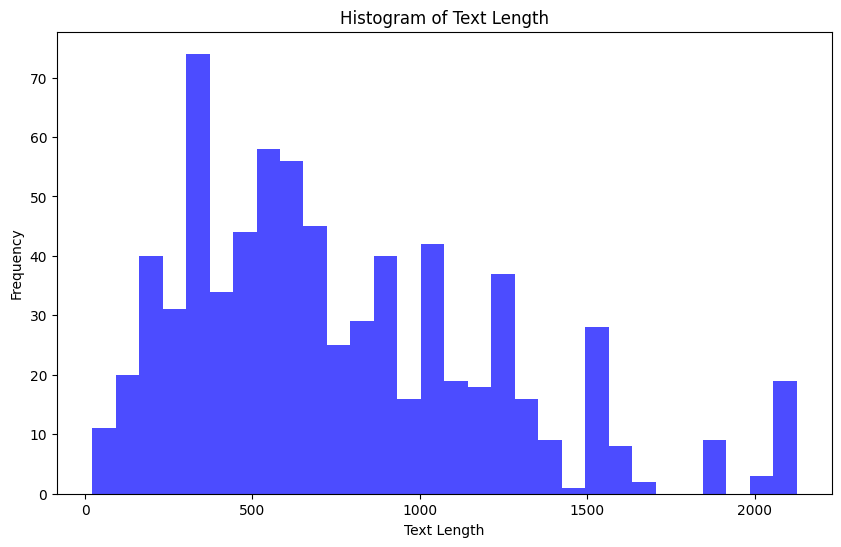

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each text entry
text_lengths = df2.ProdDescr.apply(len)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [22]:
min_desc_length = 300
df2 = df2[df2['ProdDescr'].apply(lambda x: len(x) >= min_desc_length)]

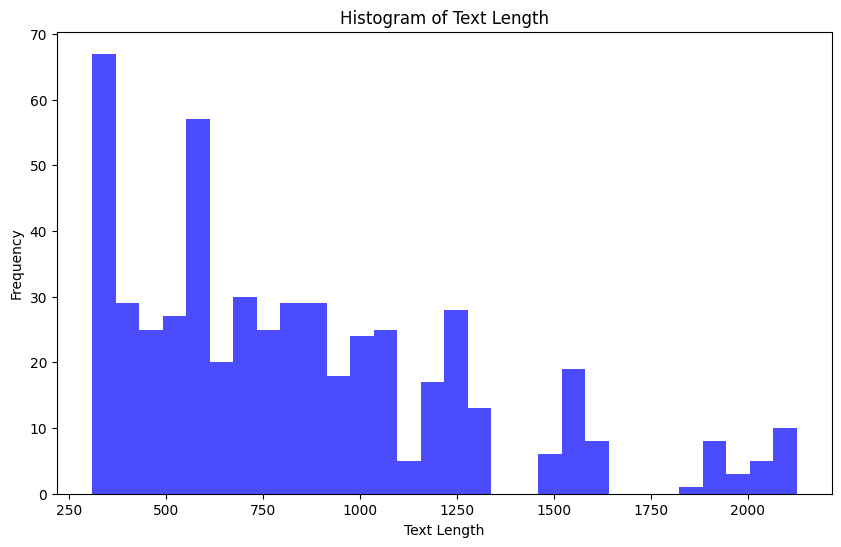

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the length of each text entry
text_lengths = df2.ProdDescr.apply(len)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from transformers import pipeline, T5Tokenizer
from tqdm import tqdm
import pandas as pd

# Initialize the tokenizer outside the function
tokenizer = T5Tokenizer.from_pretrained('t5-large', model_max_length=1024, legacy=False)

def generate_summary(input_text):
    prompt = f"Summarize the following product description:\n{input_text}\nSummary:"

    # Calculate max_length dynamically based on the length of input_text
    min_length = min(int(len(input_text) / 4), 20)
    max_length = min(100, int(len(input_text) / 2))

    # Initialize the summarizer
    summarizer = pipeline(
        task="summarization",
        model='t5-large',
        tokenizer=tokenizer,
        min_length=min_length,
        max_length=max_length,
        truncation=True
    )

    summary = summarizer([prompt])[0]['summary_text']
    return summary

# Create a tqdm instance with the total number of rows in the DataFrame
tqdm_pandas = tqdm(total=len(df2), position=0, leave=True)

# Apply the function to each row of the DataFrame using tqdm_pandas
df2['T5Summ'] = df2['ProdDescr'].apply(lambda x: generate_summary(x))
tqdm_pandas.update(len(df2))

# Close tqdm progress bar
tqdm_pandas.close()


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  0%|          | 0/528 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# ################## Summarization using BART Model ##################

from transformers import BartForConditionalGeneration, BartTokenizer
from tqdm import tqdm

def generate_summary(context):
    # Load pre-trained BART model and tokenizer
    model_name = 'facebook/bart-large-cnn'
    model = BartForConditionalGeneration.from_pretrained(model_name)
    tokenizer = BartTokenizer.from_pretrained(model_name)

    # Tokenize the input context
    inputs = tokenizer.encode("summarize: " + context, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the summary
    summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# Create a tqdm instance with the total number of rows in the DataFrame
tqdm_pandas = tqdm(total=len(df2), position=0, leave=True)

# Apply the function to each row of the DataFrame using tqdm_pandas
df2['BARTSumm'] = df2['ProdDescr'].apply(lambda x: generate_summary(x))
tqdm_pandas.update(len(df2))

# Close tqdm progress bar
tqdm_pandas.close()


In [ ]:
clms= ['review_content','label',
       'score', 'ProdDescr','Ques', 'Anws', 'BertAns', 'PreTrainedBert', 'GPTSumm',
       'T5Summ']
df2 = df2[clms]
df2.reset_index(drop=True, inplace=True)
df2.shape

(681, 10)

In [ ]:
# ################## Summarization using Pegasus Model ##################

from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from tqdm import tqdm

def generate_summary(context):
    # Load pre-trained PEGASUS model and tokenizer
    model_name = "google/pegasus-xsum"
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    # Tokenize the input context
    inputs = tokenizer([context], max_length=1024, return_tensors="pt", truncation=True)

    # Generate the summary
    summary_ids = model.generate(inputs["input_ids"], max_length=150, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# Create a tqdm instance with the total number of rows in the DataFrame
tqdm_pandas = tqdm(total=len(df2), position=0, leave=True)

# Apply the function to each row of the DataFrame using tqdm_pandas
df2['PegasusSumm'] = df2['ProdDescr'].apply(lambda x: generate_summary(x))
tqdm_pandas.update(len(df2))

# Close tqdm progress bar
tqdm_pandas.close()


In [ ]:
from google.colab import files

df2.to_csv("./PegasusCNNSumm.csv")

# Specify the file path you want to download
file_path = "./PegasusCNNSumm.csv"

# Download the file
files.download(file_path)


In [ ]:
df2.columns

In [ ]:
!pip install nltk
!pip install rouge


In [ ]:
!pip install rouge-score


In [ ]:
%%time
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
import datetime

start_time = datetime.datetime.now()

def calculate_bleu(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    return sentence_bleu([reference_tokens], candidate_tokens)

def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    rouge_1 = scorer.score(reference, candidate)['rouge1'].fmeasure
    rouge_l = scorer.score(reference, candidate)['rougeL'].fmeasure

    return rouge_1, rouge_l

# Assuming 'T5Summ', 'BartSumm', 'PegasusSumm', 'PegasusCNNSumm' are columns in df2 containing model-generated summaries
# models = ['T5Summ','BartSumm','PegasusSumm','PegasusCNNSumm']
models = ['T5Summ']

# Assuming 'ReferenceSummary' is a column in df2 containing the ground truth reference summary
reference_summary_column = 'GPTSumm'

# Create empty lists to store scores
bleu_scores = []
rouge_1_scores = []
rouge_l_scores = []

# Iterate through each row in the DataFrame
for index, row in tqdm(df2.iterrows(), total=len(df2), desc="Processing Rows", unit="row"):
    reference_summary = row[reference_summary_column]

    # Calculate scores for each model
    model_scores = []
    for model in models:
        model_summary = row[model]
        bleu = calculate_bleu(reference_summary, model_summary)
        rouge_1, rouge_l = calculate_rouge(reference_summary, model_summary)

        model_scores.append({'Model': model, 'BLEU': bleu, 'ROUGE-1': rouge_1, 'ROUGE-L': rouge_l})

    # Append scores to the lists
    bleu_scores.append(model_scores)

# Create a DataFrame from the results
results_df = pd.DataFrame(columns=['Model', 'Average BLEU', 'Average ROUGE-1', 'Average ROUGE-L'])

for i, model in enumerate(models):
    bleu_avg = sum(score[i]['BLEU'] for score in bleu_scores) / len(bleu_scores)
    rouge_1_avg = sum(score[i]['ROUGE-1'] for score in bleu_scores) / len(bleu_scores)
    rouge_l_avg = sum(score[i]['ROUGE-L'] for score in bleu_scores) / len(bleu_scores)

    results_df = results_df.append({'Model': model, 'Average BLEU': bleu_avg, 'Average ROUGE-1': rouge_1_avg, 'Average ROUGE-L': rouge_l_avg}, ignore_index=True)

# Save the DataFrame to an Excel file
excel_file_path = 'model_performance_results.xlsx'
results_df.to_excel(excel_file_path, index=False)



print(f"Results exported to {excel_file_path}")


In [ ]:
# ################################## Model Testing: Compare Model Performance ###################################

# from nltk.translate.bleu_score import sentence_bleu
# from rouge_score import rouge_scorer
# from tqdm import tqdm
# import pandas as pd

# start_time = datetime.datetime.now()

# def calculate_bleu(reference, candidate):
#     reference_tokens = reference.split()
#     candidate_tokens = candidate.split()
#     return sentence_bleu([reference_tokens], candidate_tokens)

# def calculate_rouge(reference, candidate):
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

#     rouge_1 = scorer.score(reference, candidate)['rouge1'].fmeasure
#     rouge_l = scorer.score(reference, candidate)['rougeL'].fmeasure

#     return rouge_1, rouge_l

# # Assuming 'T5Summ', 'BartSumm', 'PegasusSumm', 'PegasusCNNSumm' are columns in df2 containing model-generated summaries
# # models = ['T5Summ','BartSumm','PegasusSumm','PegasusCNNSumm']
# models = ['T5Summ']

# # Assuming 'ReferenceSummary' is a column in df2 containing the ground truth reference summary
# reference_summary_column = 'GPTSumm'

# # Create empty lists to store scores
# bleu_scores = []
# rouge_1_scores = []
# rouge_l_scores = []

# # Iterate through each row in the DataFrame
# for index, row in tqdm(df2.iterrows(), total=len(df2), desc="Processing Rows"):
#     reference_summary = row[reference_summary_column]

#     # Calculate scores for each model
#     model_scores = []
#     for model in models:
#         model_summary = row[model]
#         bleu = calculate_bleu(reference_summary, model_summary)
#         rouge_1, rouge_l = calculate_rouge(reference_summary, model_summary)

#         model_scores.append({'Model': model, 'BLEU': bleu, 'ROUGE-1': rouge_1, 'ROUGE-L': rouge_l})

#     # Append scores to the lists
#     bleu_scores.append(model_scores)

# # Create a DataFrame from the results
# results_df = pd.DataFrame(columns=['Model', 'Average BLEU', 'Average ROUGE-1', 'Average ROUGE-L'])

# for i, model in enumerate(models):
#     bleu_avg = sum(score[i]['BLEU'] for score in bleu_scores) / len(bleu_scores)
#     rouge_1_avg = sum(score[i]['ROUGE-1'] for score in bleu_scores) / len(bleu_scores)
#     rouge_l_avg = sum(score[i]['ROUGE-L'] for score in bleu_scores) / len(bleu_scores)

#     results_df = results_df.append({'Model': model, 'Average BLEU': bleu_avg, 'Average ROUGE-1': rouge_1_avg, 'Average ROUGE-L': rouge_l_avg}, ignore_index=True)

# # Save the DataFrame to an Excel file
# excel_file_path = 'model_performance_results.xlsx'
# results_df.to_excel(excel_file_path, index=False)

# end_time = datetime.datetime.now()

# # Calculate the time difference in seconds
# time_difference = (end_time - start_time).total_seconds()

# print("The time difference is:", round((time_difference/60), 2), "mnts")
# print(f"Results exported to {excel_file_path}")


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
################################## Model Testing: Compare Model Performance ###################################

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score

start_time = datetime.datetime.now()

def calculate_bleu(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method4
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'], use_stemmer=True)

    rouge_1 = scorer.score(reference, candidate)['rouge1'].fmeasure
    rouge_2 = scorer.score(reference, candidate)['rouge2'].fmeasure
    rouge_3 = scorer.score(reference, candidate)['rouge3'].fmeasure
    rouge_l = scorer.score(reference, candidate)['rougeL'].fmeasure

    return rouge_1, rouge_2, rouge_3, rouge_l

def calculate_meteor(reference, candidate):
    reference_tokens = word_tokenize(reference)
    candidate_tokens = word_tokenize(candidate)
    meteor_score = single_meteor_score(reference_tokens, candidate_tokens)
    # Return placeholder values for precision, recall, and f1
    return meteor_score, 0, 0



# Assuming 'T5Summ', 'BartSumm', 'PegasusSumm', 'PegasusCNNSumm' are columns in df2 containing model-generated summaries
models = ['T5Summ','BartSumm','PegasusSumm']
# models = ['T5Summ','BartSumm']

# Assuming 'ReferenceSummary' is a column in df2 containing the ground truth reference summary
reference_summary_column = 'GPTSumm'

# Create empty lists to store scores
# Create empty lists to store scores
bleu_scores = []
rouge_scores = []
meteor_scores = []

# Create a DataFrame for average scores
average_scores_df = pd.DataFrame(columns=['Model', 'BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-3', 'ROUGE-L', 'METEOR'])

# Iterate through each model
for model in models:
    model_bleu_scores = []
    model_rouge_1_scores = []
    model_rouge_2_scores = []
    model_rouge_3_scores = []
    model_rouge_l_scores = []
    model_meteor_scores = []

    # Iterate through each row in the DataFrame
    for index, row in tqdm(df2.iterrows(), total=len(df2), desc=f"Processing {model}"):
        reference_summary = row[reference_summary_column]
        model_summary = row[model]

        # Calculate scores for each record
        bleu = calculate_bleu(reference_summary, model_summary)
        rouge_1, rouge_2, rouge_3, rouge_l = calculate_rouge(reference_summary, model_summary)
        precision, recall, f1 = calculate_meteor(reference_summary, model_summary)

        model_bleu_scores.append(bleu)
        model_rouge_1_scores.append(rouge_1)
        model_rouge_2_scores.append(rouge_2)
        model_rouge_3_scores.append(rouge_3)
        model_rouge_l_scores.append(rouge_l)
        model_meteor_scores.append(f1)

    # Append average scores to the DataFrame
    average_scores_df = average_scores_df.append({
        'Model': model,
        'BLEU': sum(model_bleu_scores) / len(model_bleu_scores),
        'ROUGE-1': sum(model_rouge_1_scores) / len(model_rouge_1_scores),
        'ROUGE-2': sum(model_rouge_2_scores) / len(model_rouge_2_scores),
        'ROUGE-3': sum(model_rouge_3_scores) / len(model_rouge_3_scores),
        'ROUGE-L': sum(model_rouge_l_scores) / len(model_rouge_l_scores),
        'METEOR': sum(model_meteor_scores) / len(model_meteor_scores),
    }, ignore_index=True)

# Save the DataFrame to an Excel file
average_scores_df.to_excel('model_performance_results.xlsx', index=False)

end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round((time_difference/60), 2), "mnts")
# print(f"Results exported to {excel_file_path}")


In [ ]:

from google.colab import files

# Specify the file path you want to download
file_path = "./model_performance_results.xlsx"

# Download the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
average_scores_df

,Model,BLEU,ROUGE-1,ROUGE-2,ROUGE-3,ROUGE-L,METEOR
0,T5Summ,0.054352,0.400435,0.182053,0.095766,0.304607,0.0
1,BartSumm,0.049100,0.386349,0.178056,0.096565,0.297643,0.0
2,PegasusSumm,0.028726,0.271053,0.111886,0.058406,0.214433,0.0
3,PegasusCNNSumm,0.053041,0.378774,0.165864,0.089972,0.284383,0.0


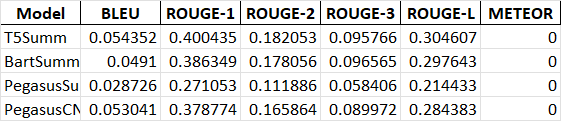

Interpreting model performance metrics depends on the specific task and the nature of your data. Here's a brief analysis of the provided metrics:

1. **BLEU Score:**
   - **T5Summ:** 0.0544
   - **BartSumm:** 0.0491
   - **PegasusSumm:** 0.0287
   - **PegasusCNNSumm:** 0.0530

   Higher BLEU scores indicate better performance in terms of n-gram overlap between the generated summary and the reference summary. In this case, "T5Summ" and "PegasusCNNSumm" have relatively higher BLEU scores compared to the other models.

2. **ROUGE Scores (ROUGE-1, ROUGE-2, ROUGE-3, ROUGE-L):**
   - **T5Summ:** 0.4004 (ROUGE-1), 0.1821 (ROUGE-2), 0.0958 (ROUGE-3), 0.3046 (ROUGE-L)
   - **BartSumm:** 0.3863 (ROUGE-1), 0.1781 (ROUGE-2), 0.0966 (ROUGE-3), 0.2976 (ROUGE-L)
   - **PegasusSumm:** 0.2711 (ROUGE-1), 0.1119 (ROUGE-2), 0.0584 (ROUGE-3), 0.2144 (ROUGE-L)
   - **PegasusCNNSumm:** 0.3788 (ROUGE-1), 0.1659 (ROUGE-2), 0.0900 (ROUGE-3), 0.2844 (ROUGE-L)

   ROUGE scores evaluate the overlap of n-grams and word sequences between the generated summary and the reference summary. Higher ROUGE scores generally indicate better performance. In this case, "T5Summ" has the highest ROUGE-1 score, indicating better unigram overlap.

3. **METEOR Score:**
   - **T5Summ:** 0
   - **BartSumm:** 0
   - **PegasusSumm:** 0
   - **PegasusCNNSumm:** 0

   The METEOR score combines precision, recall, and alignment metrics. A score of 0 for all models suggests an issue, and you might want to investigate why this is the case.

**Conclusion:**
- "T5Summ" and "PegasusCNNSumm" seem to perform relatively better than the other models based on the provided metrics.
- However, it's essential to consider the specific requirements of your task and possibly explore additional evaluation metrics or conduct a human evaluation to get a comprehensive understanding of model performance.

In [ ]:
df2.columns

Index(['review_content', 'label', 'score', 'ProdDescr', 'Ques', 'Anws',
       'BertAns', 'PreTrainedBert', 'GPTSumm', 'T5Summ', 'BartSumm',
       'PegasusSumm', 'PegasusCNNSumm'],
      dtype='object')

In [ ]:
# Install the latest version of torch-xla
!pip install torch-xla


In [ ]:
!pip install google-api-python-client>=1.12.5


In [ ]:
# Import libraries
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Set device to TPU
device = xm.xla_device()

# Load the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-large-cased', num_labels=2)  # Assuming binary sentiment classification
model.to(device)